Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:
* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

In [17]:
%pylab inline
import pandas as pd
import numpy as np

frame = pd.read_csv("..\..\Data\credit_card_default_analysis.csv", sep=",", header=0)
frame.head()

Populating the interactive namespace from numpy and matplotlib


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Задание
## Размер кредитного лимита (LIMIT_BAL).

В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:

### a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки
Определим функции для построения интервальных оценок с помощью метода bootstrap

In [18]:
from scipy import stats
def get_bootstrap_samples(data, n_samples):
    data_length = len(data)
    indices = np.random.randint(0, data_length, (n_samples, data_length))
    return data[indices]
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries
def calculate_median_confidence_interval(data, samples_count = 1000, alpha = 0.05):
    median = np.median(data)
    medians = map(lambda samples_group: np.median(samples_group), get_bootstrap_samples(data, samples_count))
    confint = stat_intervals(medians, alpha)
    return (median, confint)
def compare_distributions(data1, data2, samples_count, alpha):
    median_deltas = map(
        lambda (s_median,d_median): s_median-d_median,
        zip(
            map(lambda samples_group: np.median(samples_group), get_bootstrap_samples(data1, samples_count)),
            map(lambda samples_group: np.median(samples_group), get_bootstrap_samples(data2, samples_count))
        )
    )
    return stat_intervals(median_deltas, alpha)

Разделим данные на две группы default и success

In [19]:
default_group = frame[frame["default"] == 1]
success_group = frame[frame["default"] == 0]
default_group_limits = default_group["LIMIT_BAL"].as_matrix()
success_group_limits = success_group["LIMIT_BAL"].as_matrix()

Попытаемся визуально сравнить распределение кредитного лимита

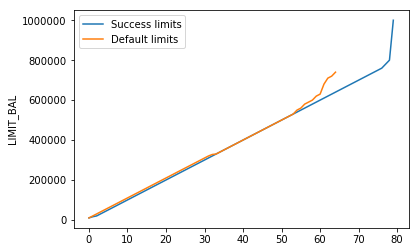

In [15]:
pylab.ylabel("LIMIT_BAL")
pylab.plot(sorted(list(set(success_group_limits))), label="Success limits")
pylab.plot(sorted(list(set(default_group_limits))), label="Default limits")
pylab.legend()
pylab.show()

По графику заметно, что есть разница между размерами кредитного лимита для групп "success" и "default". Для группы success размер кредитного лимита выше. Докажем, с помощью доверительных интервалов, что различие между значениями в этих группах действительно есть.

In [20]:
samples_count = 1000
alpha = 0.05
default_limit_confint = calculate_median_confidence_interval(default_group_limits, samples_count, alpha)
success_limit_confint = calculate_median_confidence_interval(success_group_limits, samples_count, alpha)
median_delta_confint = compare_distributions(success_group_limits, default_group_limits, samples_count, alpha)
print "Default limit max value: %.4f\tmin value: %.4f" % (np.max(default_group_limits), np.min(default_group_limits))
print "Success limit max value: %.4f\tmin value: %.4f" % (np.max(success_group_limits), np.min(success_group_limits))
print "Default median: %.4f\tConfidence interval: %s" % default_limit_confint
print "Success median: %.4f\tConfidence interval: %s" % success_limit_confint
print "Confidence interval for difference between \"default\" and \"success\" groups is %s" % median_delta_confint

Default limit max value: 740000.0000	min value: 10000.0000
Success limit max value: 1000000.0000	min value: 10000.0000
Default median: 90000.0000	Confidence interval: [ 80000.  90000.]
Success median: 150000.0000	Confidence interval: [ 150000.  150000.]
Confidence interval for difference between "default" and "success" groups is [ 60000.  70000.]


Доверительные интервалы для медиан в группах "success" и "default" далеко отстоят друг от друга.
Доверительный интервал для разницы медианных значений в этих группах далеко отстоит от нуля.
Из этого можно сделать вывод, что гипотеза о равенстве распределений отвергается.
### b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?
Мы имеем две независимые выборки "success" и "default". Чтобы сравнить эти выборки можно воспользоваться непараметрическим ранговым критерием Манна-Уитни.

In [21]:
print "Mann-Whitney criterion p-value:"
print stats.mannwhitneyu(default_group_limits, success_group_limits, alternative="two-sided").pvalue

Mann-Whitney criterion p-value:
1.22554858182e-189


## Пол (SEX)
### Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.
Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)
Выделим две группы

In [22]:
default_group_sex = default_group["SEX"].as_matrix()
success_group_sex = success_group["SEX"].as_matrix()
# Определим функции, необходимые для проверки гипотезы о доле
def proportions_confint_diff(first_vector, second_vector, alpha = 0.05):
    count1 = float(len(first_vector))
    count2 = float(len(second_vector))
    p1 = float(len(filter(lambda x: x == 1, first_vector)))/count1
    p2 = float(len(filter(lambda x: x == 1, second_vector)))/count2
    z = stats.norm.ppf(1. - alpha / 2.)

    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1. - p1)/ count1 + p2 * (1 - p2)/ count2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1. - p1)/ count1 + p2 * (1 - p2)/ count2)
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(len(filter(lambda x: x == 1, sample1))) / n1
    p2 = float(len(filter(lambda x: x == 1, sample2))) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(sample1, sample2, alternative = 'two-sided'):
    z_stat = proportions_diff_z_stat_ind(sample1, sample2)
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

Сравним доли мужчин в группах "default" и "success" на основе доверительных интервалов

In [23]:
print "Proportion confidential interval is [%.4f; %.4f]" % proportions_confint_diff(default_group_sex, success_group_sex)

Proportion confidential interval is [0.0336; 0.0605]


Доверительный интервал не содержит 0, соответственно можно утверждать, что гендерный состав вернувших и не вернувших кредит людей отличается.

Теперь сравним доли мужчин в тех-же группах на основе z-критерия для двух независимых выборок

In [24]:
pvalue = proportions_diff_z_test(default_group_sex, success_group_sex, alternative='two-sided')
print "p-value: ", pvalue

p-value:  4.47286652161e-12


Достигаемый уровень значимости Z-критерия p-value для этих двух выборок сильно меньше 0.05. Гипотеза о равенстве доли мужчин в выборках "default" и "success" с уверенностью отвергается.

## Образование (EDUCATION)
### Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.
Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек.

Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости?

Наличие какого образования является наилучшим индикатором того, что человек отдаст долг?

Наоборот, не отдаст долг?

In [25]:
# Выделим две группы
success_group_edu = success_group["EDUCATION"].as_matrix()
default_group_edu = default_group["EDUCATION"].as_matrix()

Попытаемся сравнить их визуально с помощью гистограммы

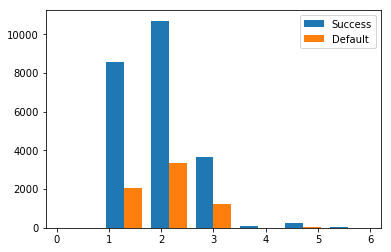

In [24]:
pylab.hist([success_group_edu, default_group_edu], 7, label = ["Success", "Default"])
pylab.legend()

По такому графику сложно как-то интерпретировать разницу в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Очевидно, разных группах обучения разное количество людей. Выборки не масштабированы

In [26]:
def build_contingency_table_bar_chart(contingency_table, row_groups, column_groups):
    for (row_index,row_name) in enumerate(row_groups):
        column_counts = map(lambda cell: float(cell), contingency_table[row_index])
        overall_count = sum(column_counts)
        if overall_count > 0:
            for (column_count,column_name) in zip(column_counts, column_groups):
                pylab.bar(row_index, column_count/overall_count, label = ("%s %s (%.0f)" % (row_name, column_name, column_count)))
    pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pylab.show()
def v_Cramer_correlation(table):
    chi_stat = stats.chi2_contingency(table)[0]
    k_min = np.min(table.shape)
    n = np.sum(table)
    return np.sqrt(chi_stat/(n*(k_min-1)))

Построим таблицу сопряженности, в ячейках этой таблицы находится количество человек, для которых значения признаков совпадают

In [27]:
education_groups = ["doctor","master","bachelor","scholar","basic","other","n/a"]
edu_contingency_table = pd.pivot_table(
    frame[["EDUCATION", "default", "LIMIT_BAL"]],
    values=["LIMIT_BAL"],
    index=["EDUCATION"],
    columns=["default"],
    fill_value = 0,
    aggfunc='count').as_matrix()


Для этой таблицы сопряженности построим bar chart, где сравниваются отношения значений success/count и default/count. Эти значения фактически представляют собой долю клиентов вернувших кредит и долю клиентов просрочивших выплаты.
Эти доли принимают значения от 0 до 1 и соответственно имеют одиаковый масштаб.

In [34]:
edu_contingency_table

array([[   14,     0],
       [ 8549,  2036],
       [10700,  3330],
       [ 3680,  1237],
       [  116,     7],
       [  262,    18],
       [   43,     8]], dtype=int64)

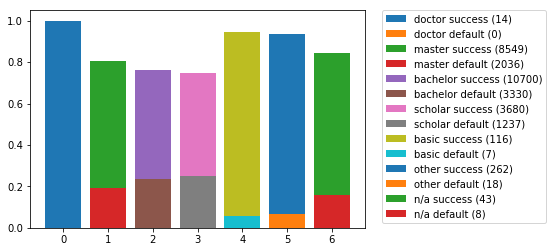

In [28]:
build_contingency_table_bar_chart(edu_contingency_table, education_groups, ["success", "default"])

Поскольку оба признака "EDUCATION" и "default" де-факто категориальные, мы можем посчитать меру взаимосвязи между ними с помощью коэффициента V Крамера

In [28]:
print "V-Cramer statistic is: %.4f" % v_Cramer_correlation(edu_contingency_table)
print "p-value:", stats.chi2_contingency(edu_contingency_table)[1]

V-Cramer statistic is: 0.0738
p-value: 1.23326262454e-32


Значение коэффициента V Крамера не очень велико, однако p-value критерия хи-квадрат говорит нам, что это значение статистически значимо.
Проверим корректность использования критерия хи-квадрат

In [44]:
edu_contingency_table_cells = edu_contingency_table.reshape(-1)
count_is_enough = len(filter(lambda val: val > 5, edu_contingency_table_cells))
all_cells_count = len(edu_contingency_table_cells)
elements_count = sum(edu_contingency_table_cells)
print u"Общее количество элементов: %i. Процент ячеек, где количество элементов больше 5: %.4f%%" % (elements_count,(float(count_is_enough)*100/all_cells_count))

Общее количество элементов: 30000. Процент ячеек, где количество элементов больше 5: 92.8571%


Число ячеек, где количество элементов больше 5 составляет более 80%, а количество ячеек сильно больше 40.
Применение критерия хи-квадрат корректно.

Судя по графику чаще всего отдают долг люди с докторской степенью. Реже всего, - люди со школьным образованием.

## Возраст (AGE):
Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы:

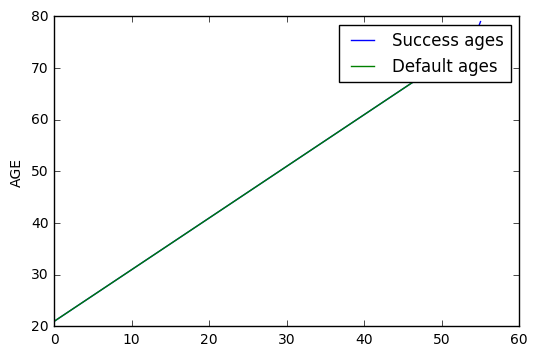

In [30]:
default_group_ages = default_group["AGE"].as_matrix()
success_group_ages = success_group["AGE"].as_matrix()
pylab.ylabel("AGE")
pylab.plot(sorted(list(set(success_group_ages))), label="Success ages")
pylab.plot(sorted(list(set(default_group_ages))), label="Default ages")
pylab.legend()
pylab.show()

a) о равенстве медианных значений возрастов людей

In [31]:
default_ages_confint = calculate_median_confidence_interval(default_group_ages, samples_count, alpha)
success_ages_confint = calculate_median_confidence_interval(success_group_ages, samples_count, alpha)
median_delta_ages_confint = compare_distributions(success_group_ages, default_group_ages, samples_count, alpha)
print "Default ages max value: %.4f\tmin value: %.4f" % (np.max(default_group_ages), np.min(default_group_ages))
print "Success ages max value: %.4f\tmin value: %.4f" % (np.max(success_group_ages), np.min(success_group_ages))
print "Default ages median: %.4f\tConfidence interval: %s" % default_ages_confint
print "Success ages median: %.4f\tConfidence interval: %s" % success_ages_confint
print "Confidence interval for difference between ages in \"default\" and \"success\" groups is %s" % median_delta_ages_confint

Default ages max value: 75.0000	min value: 21.0000
Success ages max value: 79.0000	min value: 21.0000
Default ages median: 34.0000	Confidence interval: [ 34.  35.]
Success ages median: 34.0000	Confidence interval: [ 34.  34.]
Confidence interval for difference between ages in "default" and "success" groups is [-1.  0.]


Доверительный интервал для разницы возрастов между \"success\" и \"default\" группами содержит ноль.
Гипотеза о равенстве возрастов в этих группах не отвергается.

b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

In [33]:
print "Mann-Whitney criterion p-value:"
print stats.mannwhitneyu(default_group_ages, success_group_ages, alternative="two-sided").pvalue

Mann-Whitney criterion p-value:
0.37250354349


Значимы ли полученные результаты с практической точки зрения ?

Мы определили, что

* размер кредитного лимита для людей не допускающих просрочки значимо выше.
* гендерный состав людей вернувших и просрочивших долг значимо различается.
* доля мужчин в группе не допускающих просрочку выше.
* образование не сильно, но все-таки значимо влияет на вероятность возврата долга.
* можно утверждать, что люди с лучшим образованием чаще возвращают долг. (хотя здесь статистику портят группы other, n/a и basic).
* возрастной состав в группах вернувших и просрочивших долг примерно одинаков.

На мой взгляд полученные результаты совпадают с очень частой политикой выдачи кредитов банками. С другой стороны стоит отметить, что эти признаки скорее выглядят вспомогательными и первоочередными критериями скорее являются доход и трудоустроенность клиента.